C:\Users\belia\anaconda3\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Execution time: 11.940998554229736 seconds
Best coefficients: [ 0.34047873  8.24764929 -4.52376107 -2.79838073  3.04693287]
Best fitness: 741.7832141302824


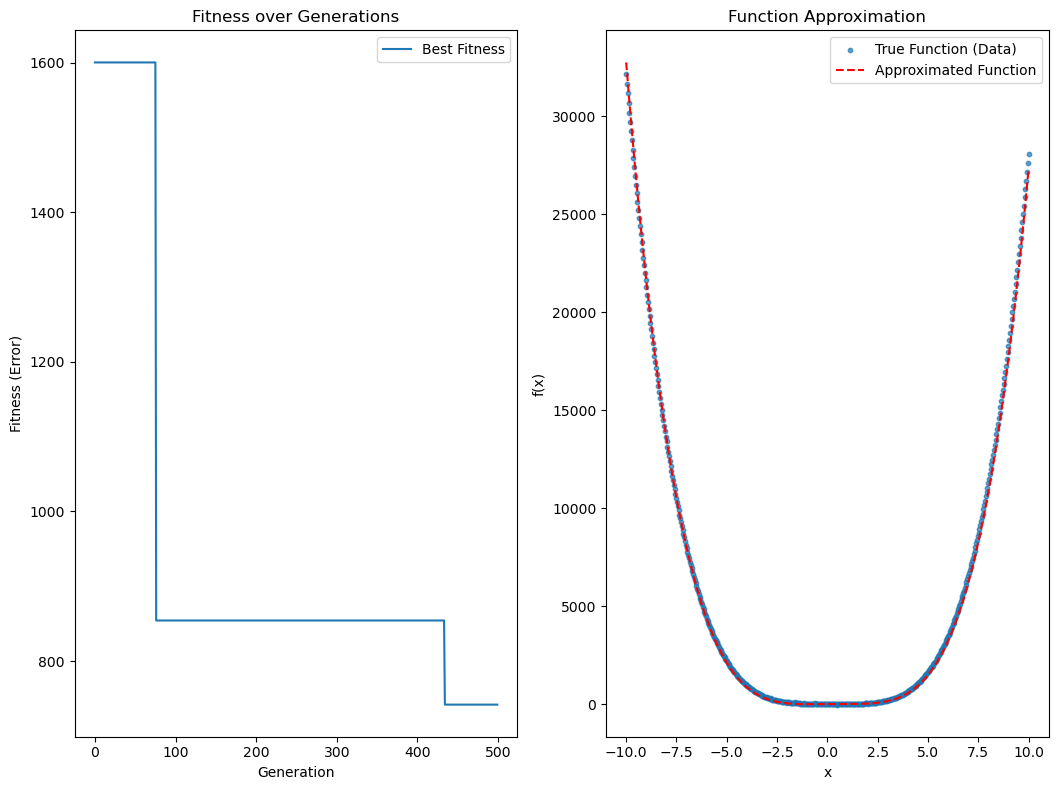

In [11]:
import numpy as np
import cupy as cp
from numba import cuda
import time
import matplotlib.pyplot as plt

POLYNOMIAL_DEGREE = 4
POPULATION_SIZE = 1000
MAX_GENERATIONS = 500
MUTATION_RATE = 0.01

# Генерация случайных данных
np.random.seed(42)
x_points = np.linspace(-10, 10, 500)
y_points = 3 * x_points**4 - 2 * x_points**3 + x_points**2 - 5 * x_points + 7 + np.random.normal(0, 10, len(x_points))

@cuda.jit
def fitness_kernel(population, x_points, y_points, fitness):
    idx = cuda.grid(1)
    if idx < population.shape[0]:
        max_error = 0
        for i in range(len(x_points)):
            approx = 0
            for j in range(POLYNOMIAL_DEGREE + 1):
                approx += population[idx, j] * (x_points[i] ** j)
            error = abs(y_points[i] - approx)
            if error > max_error:
                max_error = error
        fitness[idx] = max_error

# Инициализация популяции
population = cp.random.uniform(-10, 10, (POPULATION_SIZE, POLYNOMIAL_DEGREE + 1))
fitness = cp.zeros(POPULATION_SIZE)

# Основной цикл генетического алгоритма
start_time = time.time()
best_fitness_per_generation = []
for generation in range(MAX_GENERATIONS):
    # Вычисление приспособленности
    threads_per_block = 256
    blocks_per_grid = (POPULATION_SIZE + threads_per_block - 1) // threads_per_block
    fitness_kernel[blocks_per_grid, threads_per_block](population, cp.asarray(x_points), cp.asarray(y_points), fitness)

    # Селекция (сортировка по приспособленности)
    sorted_indices = cp.argsort(fitness)
    population = population[sorted_indices]
    fitness = fitness[sorted_indices]

    # Запись лучшего результата
    best_fitness_per_generation.append(cp.asnumpy(fitness[0]))

    # Кроссовер
    for i in range(POPULATION_SIZE // 2, POPULATION_SIZE, 2):
        parent1, parent2 = population[i - 1], population[i]
        cross_point = np.random.randint(1, POLYNOMIAL_DEGREE)
        population[i, :cross_point] = parent1[:cross_point]
        population[i, cross_point:] = parent2[cross_point:]
        population[i + 1, :cross_point] = parent2[:cross_point]
        population[i + 1, cross_point:] = parent1[cross_point:]

    # Мутация
    for i in range(1, POPULATION_SIZE):
        if np.random.rand() < MUTATION_RATE:
            gene_to_mutate = np.random.randint(0, POLYNOMIAL_DEGREE + 1)
            population[i, gene_to_mutate] += np.random.normal(0, 1)

execution_time = time.time() - start_time
best_individual = population[0]

print("Время выполнения:", execution_time, "seconds")
print("Лучшие коэффициенты:", cp.asnumpy(best_individual))

plt.figure(figsize=(16, 8))


# Сравнение исходной функции и аппроксимации
plt.subplot(1, 3, 1)
true_values = y_points
approximated_values = sum(cp.asnumpy(best_individual[i]) * x_points**i for i in range(POLYNOMIAL_DEGREE + 1))
plt.scatter(x_points, true_values, label='True Function (Data)', s=10, alpha=0.7)
plt.plot(x_points, approximated_values, label='Approximated Function', color='red', linestyle='--')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Function Approximation')
plt.legend()

plt.tight_layout()
plt.show()
